## Experiment

Another example of estimating the ARE in a simple setting.

<AxesSubplot:>

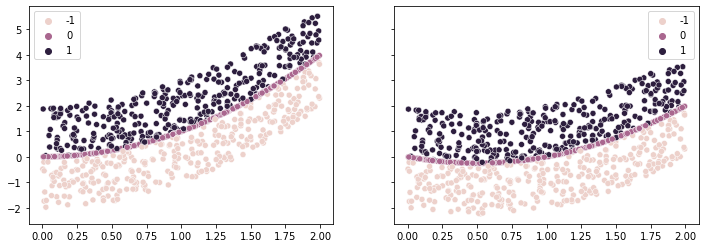

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from tqdm.auto import tqdm

def gaussian(mu, sigma):
    return lambda n=1: np.random.normal(mu, sigma, size=n)

def uniform(x1, x2):
    return lambda n=1: x2 - (np.random.rand(n) * (x2 - x1))

def constant(x):
    return lambda n=1: np.full((n,), x)

def categorical(x, p=None):
    x = np.array(x)
    if p is None:
        p = np.ones(x.shape[0]) / x.shape[0]
    p = np.array(p)
    assert x.shape[0] == p.shape[0]
    def _dist(n=1):
        return np.random.choice(x, size=n, p=p)
    return _dist

def bernoulli(p):
    return categorical([0,1],[1-p,p])

n = 1000
X0 = uniform(0,2)(n)
A = categorical([-1,0,1])(n)

#X1 = (categorical([-1,0,1])(n) * X0 ) ** 2 + A * uniform(2,4)(n)
X1 = X0 ** 2 + A * uniform(0,2)(n)

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, sharex=True, figsize=(12,4))
sb.scatterplot(x=X0, y=X1, hue=A, ax=axes[0]) # x movement
sb.scatterplot(x=X0, y=X1-X0, hue=A, ax=axes[1]) # x movement


In [54]:
import torch
import torch.nn as nn

class Module(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
           #nn.Linear(2,1)
            nn.Linear(2,64), nn.Tanh(),
            nn.Linear(64,1)
        )
        self.optim = torch.optim.Adam(self.parameters(), lr=0.0005)
        self.criterion = nn.MSELoss()
        
    def forward(self, x, a):
        z = torch.cat([x, a], dim=-1)
        return self.layers(z)
    
    def predict(self, x, a):
        pred_total_effect = self.forward(x, a)
        noop = torch.zeros_like(a)
        pred_exafferent_effect = model(x, noop)
        pred_reafferent_effect = pred_total_effect - pred_exafferent_effect.detach()
        return pred_total_effect, pred_reafferent_effect, pred_exafferent_effect
    
    def step(self, x1, x2, a):
        self.optim.zero_grad()
        pred_total_effect, pred_reafferent_effect, pred_exafferent_effect = self.predict(x1, a)
        pred_effect = pred_exafferent_effect + pred_reafferent_effect
        total_effect = x2 - x1
        loss = self.criterion(pred_effect, total_effect)
        loss.backward()
        self.optim.step()
        return loss.detach()
    
    def train(self, x1, x2, a, epochs):
        pbar = tqdm(range(epochs))
        for e in pbar:
            x1, x2, a = self.shuffle(x1, x2, a)
            loss = self.step(x1, x2, a)
            pbar.set_description(f"loss: {loss.item() : .5f}")
    
    def shuffle(self, *x):
        indx = torch.randperm(x[0].shape[0])
        return [z[indx] for z in x]

x0, x1, a = [torch.from_numpy(z).unsqueeze(1).float() for z in (X0, X1, A)]   

model = Module()
model.train(x0, x1, a, epochs=10000)



  0%|          | 0/10000 [00:00<?, ?it/s]

A= 1 total effect: 1.26927  reafference: 0.95186 exafference: 0.31741 
A= 0 total effect: 0.31741  reafference: 0.00000 exafference: 0.31741 
A=-1 total effect: -0.69850  reafference: -1.01591 exafference: 0.31741 


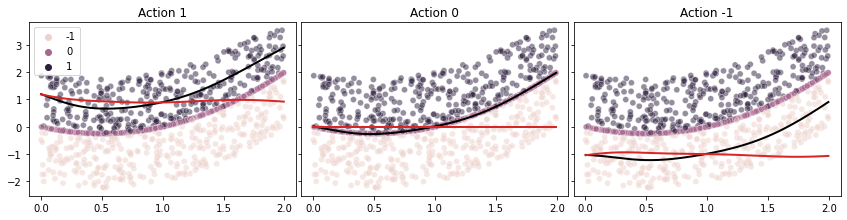

In [117]:
palette = sb.color_palette("rocket", as_cmap=True)

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(12,3))
fig.tight_layout()
plt.subplots_adjust(wspace=0.02)
t, re, ex = model.predict(x0, torch.ones_like(a))     
print(f"A= 1 total effect: {t.mean().item():.5f}  reafference: {re.mean().item():.5f} exafference: {ex.mean().item():.5f} ")   

sb.scatterplot(x=X0, y=X1-X0, hue=A, ax=axes[0], alpha=0.5).set_title("Action 1") # x movement
sb.lineplot(x=X0, y=t.squeeze().detach().cpu().numpy(), ax=axes[0], linewidth=2, color='black') # x movement
sb.lineplot(x=X0, y=re.squeeze().detach().cpu().numpy(), ax=axes[0], linewidth=2, color='tab:red') # x movement
#sb.lineplot(x=X0, y=ex.squeeze().detach().cpu().numpy(), ax=axes[0], linewidth=2, color='tab:green') # x movement


t, re, ex = model.predict(x0, torch.zeros_like(a))     
print(f"A= 0 total effect: {t.mean().item():.5f}  reafference: {re.mean().item():.5f} exafference: {ex.mean().item():.5f} ")      

sb.scatterplot(x=X0, y=X1-X0, hue=A, ax=axes[1], legend=None, alpha=0.5).set_title("Action 0")# x movement
sb.lineplot(x=X0, y=t.squeeze().detach().cpu().numpy(), ax=axes[1],linewidth=2, color='black') # x movement
sb.lineplot(x=X0, y=re.squeeze().detach().cpu().numpy(), ax=axes[1], linewidth=2, color='tab:red') # x movement
#sb.lineplot(x=X0, y=ex.squeeze().detach().cpu().numpy(), ax=axes[1], linewidth=2, color='tab:green') # x movement


t, re, ex = model.predict(x0, -torch.ones_like(a))     
print(f"A=-1 total effect: {t.mean().item():.5f}  reafference: {re.mean().item():.5f} exafference: {ex.mean().item():.5f} ")      

sb.scatterplot(x=X0, y=X1-X0, hue=A, ax=axes[2], legend=None, alpha=0.5).set_title("Action -1") # x movement
sb.lineplot(x=X0, y=t.squeeze().detach().cpu().numpy(), ax=axes[2], linewidth=2, color="black") # x movement
sb.lineplot(x=X0, y=re.squeeze().detach().cpu().numpy(), ax=axes[2], linewidth=2, color='tab:red') # x movement
#sb.lineplot(x=X0, y=ex.squeeze().detach().cpu().numpy(), ax=axes[2], linewidth=2, color='tab:green') # x movement


plt.savefig("./media/ARE-Example.png", dpi=100, bbox_inches='tight', )